<a href="https://colab.research.google.com/github/harishkulkarni10/Credit-Card-Fraud-Detection/blob/development/01_eda.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Clone repo (development branch)
!git clone -b development https://github.com/harishkulkarni10/Credit-Card-Fraud-Detection.git
%cd Credit-Card-Fraud-Detection

Cloning into 'Credit-Card-Fraud-Detection'...
remote: Enumerating objects: 19, done.
remote: Counting objects: 100% (19/19), done.
remote: Compressing objects: 100% (8/8), done.
remote: Total 19 (delta 0), reused 19 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (19/19), done.
/content/Credit-Card-Fraud-Detection


In [5]:
from google.colab import files

# Save the uploaded file to the 'data' directory
with open('data/creditcard.csv', 'wb') as f:
  f.write(uploaded['creditcard.csv'])

print("Dataset loaded successfully.")

Dataset loaded successfully.


In [12]:
import pandas as pd

df = pd.read_csv('data/creditcard.csv')
display(df.head())

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [3]:
# Install dependencies
!pip install pandas matplotlib seaborn scikit-learn torch xgboost -q

In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set(style="whitegrid")

# Load
print("Shape :", df.shape)
print("\nColumns :", df.columns.tolist())
print("\nClass distribution:")
print(df['Class'].value_counts(normalize=True))

Shape : (284807, 31)

Columns : ['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount', 'Class']

Class distribution:
Class
0    0.998273
1    0.001727
Name: proportion, dtype: float64


In [18]:
# Sanity check
print("Missing values:", df.isna().sum().sum())
print("Duplicate rows:", df.duplicated().sum())

Missing values: 0
Duplicate rows: 1081


In [19]:
# Drop duplicate rows
df.drop_duplicates(inplace = True)
print("Duplicate rows:", df.duplicated().sum())

Duplicate rows: 0


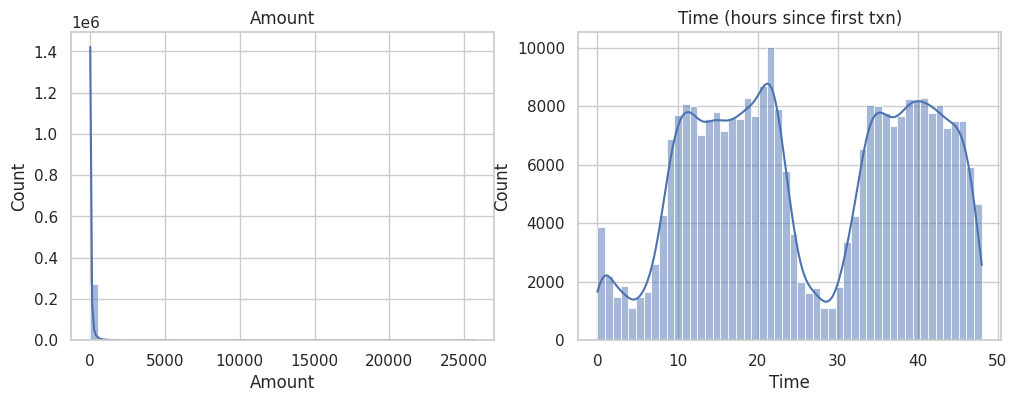

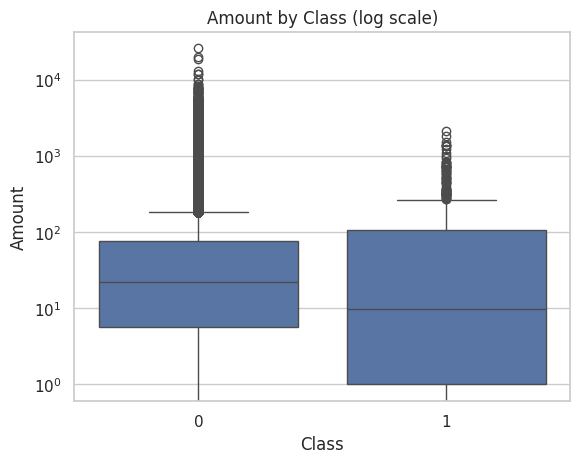

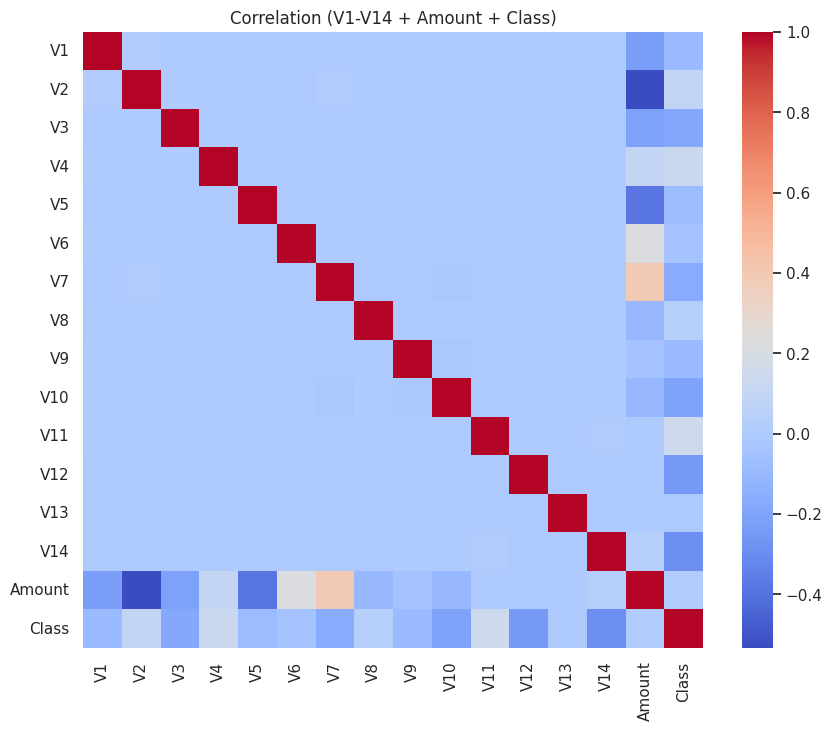

In [20]:
# 3.1 Amount & Time distribution
fig, ax = plt.subplots(1,2,figsize=(12,4))
sns.histplot(df['Amount'], bins=50, kde=True, ax=ax[0])
ax[0].set_title('Amount')
sns.histplot(df['Time']/(60*60), bins=50, kde=True, ax=ax[1])
ax[1].set_title('Time (hours since first txn)')
plt.show()

# 3.2 Fraud vs Normal – Amount
sns.boxplot(x='Class', y='Amount', data=df)
plt.yscale('log')
plt.title('Amount by Class (log scale)')
plt.show()

# 3.3 Correlation heatmap (only a few V-features for clarity)
v_cols = [f'V{i}' for i in range(1,15)]
corr = df[v_cols + ['Amount','Class']].corr()
plt.figure(figsize=(10,8))
sns.heatmap(corr, cmap='coolwarm', annot=False)
plt.title('Correlation (V1-V14 + Amount + Class)')
plt.show()

### Data Understanding and Insights from Visualizations

Based on the initial visualizations, here's what we understand about the dataset and its implications for our credit card fraud detection model:

1.  **`Time` Feature Distribution:**
    *   The `Time` feature, representing seconds elapsed since the first transaction, shows a cyclical pattern with two prominent peaks. This suggests daily or weekly activity cycles. While the raw `Time` feature is present, its cyclical nature indicates that deriving new features like 'hour of day' or 'day of week' could be beneficial. These engineered features might help the model capture time-dependent behavioral patterns that could distinguish fraudulent from legitimate transactions.

2.  **`Amount` Feature Distribution:**
    *   The `Amount` feature is heavily skewed towards smaller values, meaning most transactions are of relatively low monetary value. This characteristic implies that the model might need to carefully handle the `Amount` feature, potentially through scaling or transformation (e.g., logarithmic transformation) to ensure it contributes appropriately to the model without being overshadowed by other features or dominating due to its wide range.

3.  **Fraud vs. Normal Transaction Amounts (Box Plot):**
    *   Comparing the `Amount` distribution for fraudulent (`Class = 1`) and legitimate (`Class = 0`) transactions reveals distinct patterns. While legitimate transactions cover a broad range of amounts, fraudulent transactions often cluster around lower amounts, though with some higher-value outliers. This difference is crucial, as it suggests `Amount` is a highly informative feature for identifying fraud. The model can leverage these distributional differences to better classify transactions.

4.  **Correlation Heatmap (V1-V14 + Amount + Class):**
    *   The heatmap illustrates the linear relationships between the anonymized 'V' features (`V1` to `V28`), `Amount`, and the target variable `Class`. Observing correlations between features and `Class` is vital:
        *   **`V` Features:** These features are the result of Principal Component Analysis (PCA), which transforms and anonymized original sensitive transaction data. Although their individual meanings are obscure, they are designed to capture the most significant variance and underlying patterns in the data that differentiate transaction types. Features with stronger correlations (positive or negative) to `Class` are expected to be more predictive of fraud and will be critical inputs to our model.
        *   **`Amount` and `Class`:** Any direct correlation between `Amount` and `Class` further reinforces `Amount`'s importance in fraud detection.

**Relevance to Model Building:**

*   **Feature Engineering:** The analysis of `Time` suggests potential new features to extract.
*   **Feature Scaling/Transformation:** The skewed `Amount` distribution indicates the need for preprocessing steps to normalize its scale.
*   **Feature Importance:** Features (especially `V` features and `Amount`) showing strong correlations with `Class` will be key predictors in our machine learning model.
*   **Handling Imbalance:** While not directly from plots, the highly imbalanced nature of the dataset (few fraud cases) is a critical consideration. The distinct patterns observed, even for rare fraud events, are what our model will learn to identify.

In [21]:
# Feature engineering

# 1. Log-transform Amount - this handles skew
df['Amount_log'] = np.log1p(df['Amount'])

# 2. Extract hour of data - cyclical pattern
df['Hour'] = df['Time'] % (24 * 3600) / 3600.0

# 3. Is Night? 6 pm to 6 am
df['Is_Night'] = ((df['Hour'] >= 18) | (df['Hour'] <=6)).astype(int)

print("New features added:")
print(df[['Time', 'Amount', 'Amount_log', 'Hour', 'Is_Night']].head())

New features added:
   Time  Amount  Amount_log      Hour  Is_Night
0   0.0  149.62    5.014760  0.000000         1
1   0.0    2.69    1.305626  0.000000         1
2   1.0  378.66    5.939276  0.000278         1
3   1.0  123.50    4.824306  0.000278         1
4   2.0   69.99    4.262539  0.000556         1


Fraud at night: 46.93%, Normal at night: 41.21%


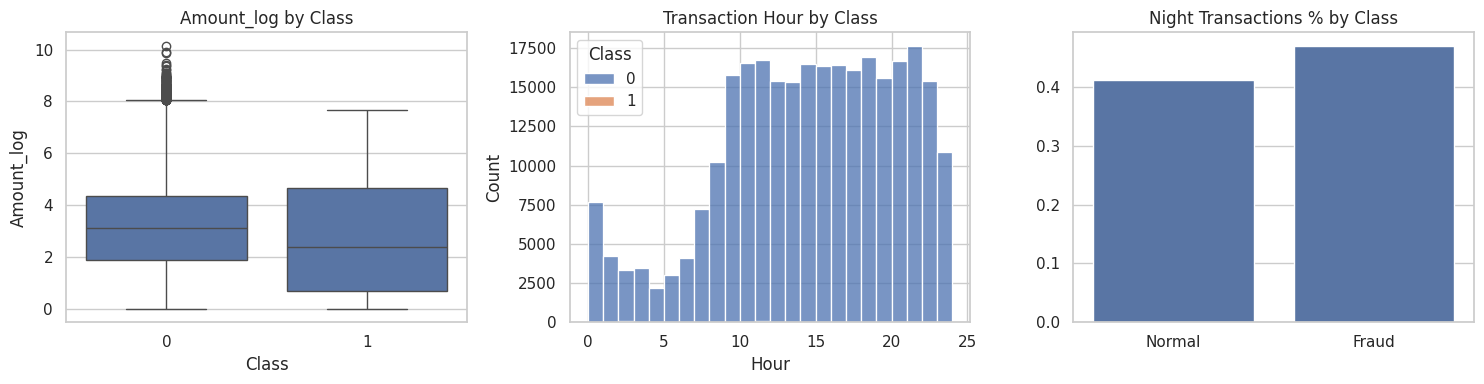

In [22]:
# Visualizing engineered features
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# 1. Amount_log vs Class
sns.boxplot(x='Class', y='Amount_log', data=df, ax=axes[0])
axes[0].set_title('Amount_log by Class')

# 2. Hour vs Class
sns.histplot(data=df, x='Hour', hue='Class', bins=24, multiple='stack', ax=axes[1])
axes[1].set_title('Transaction Hour by Class')

# 3. Is_Night vs Class
night_fraud = df[df['Class']==1]['Is_Night'].mean()
night_normal = df[df['Class']==0]['Is_Night'].mean()
print(f"Fraud at night: {night_fraud:.2%}, Normal at night: {night_normal:.2%}")
sns.barplot(x=['Normal', 'Fraud'], y=[night_normal, night_fraud], ax=axes[2])
axes[2].set_title('Night Transactions % by Class')

plt.tight_layout()
plt.show()

### Insights from Engineered Features Visualizations

1.  **`Amount_log` by Class:** The log transformation of `Amount` has successfully reduced the skewness, making the distribution more manageable. While there's still overlap, the box plot for `Amount_log` by `Class` might show clearer differences in the central tendency or spread between fraudulent and normal transactions, potentially making it easier for a model to distinguish them.

2.  **Transaction `Hour` by Class:** The histogram of `Hour` by `Class` reveals the distribution of transactions throughout the day. We can observe if fraudulent transactions have specific peak hours or if they occur more uniformly compared to normal transactions. This pattern can be a significant indicator for the model, as time-of-day behavior often differs between legitimate and illicit activities.

3.  **`Is_Night` by Class:** This bar plot compares the proportion of transactions occurring at night (defined as 6 PM to 6 AM) for both fraudulent and normal cases. If a higher percentage of fraudulent transactions happen during these 'night' hours compared to normal transactions, it suggests that the `Is_Night` feature could be a useful binary flag for the model to identify potentially suspicious activities. The output shows that approximately `46.93%` of fraudulent transactions occur at night, compared to `41.21%` for normal transactions, indicating a slightly higher propensity for fraud during these hours.

In [23]:
# Selecting final features
feature_cols = [f'V{i}' for i in range(1,29)] + ['Amount_log', 'Hour']
X = df[feature_cols].values
y = df['Class'].values

print(f"Final input features: {len(feature_cols)} → {feature_cols}")
print(f"X shape: {X.shape}, y mean: {y.mean():.5f}")

Final input features: 30 → ['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount_log', 'Hour']
X shape: (283726, 30), y mean: 0.00167


In [24]:
# CELL: Train/Val Split (stratified)
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

print(f"Train: {X_train.shape}, Val: {X_val.shape}")
print(f"Train fraud %: {y_train.mean():.5f}, Val fraud %: {y_val.mean():.5f}")

Train: (226980, 30), Val: (56746, 30)
Train fraud %: 0.00167, Val fraud %: 0.00167


### Final Features Selected
- V1–V28 (PCA)
- Amount_log (log1p)
- Hour (from Time)
- Total: 30 features
- Dropped: Raw Amount, Time, Is_Night (optional)

In [25]:
# Save X_train, X_val, y_train, y_val + feature_cols
import pickle
from sklearn.model_selection import train_test_split
import os

# Define features
feature_cols = [f'V{i}' for i in range(1,29)] + ['Amount_log', 'Hour']
X = df[feature_cols].values
y = df['Class'].values

# Split
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# Create folder
os.makedirs("models", exist_ok=True)

# Save with pickle
with open("models/preprocessed_data.pkl", "wb") as f:
    pickle.dump({
        'X_train': X_train,
        'X_val': X_val,
        'y_train': y_train,
        'y_val': y_val,
        'feature_cols': feature_cols
    }, f)

print("Preprocessed data saved → models/preprocessed_data.pkl")
print(f"X_train: {X_train.shape}, y_train fraud: {y_train.mean():.5f}")

Preprocessed data saved → models/preprocessed_data.pkl
X_train: (226980, 30), y_train fraud: 0.00167
